In [3]:
using PyPlot

In [4]:
include("sim.jl"); #include the simulator 
include("floopMap.jl") #include mapping

Import successful: sim.jl
Import successful: floopMap.jl


In [5]:
### Begin continuous state space code
# s: 5 element column vector of joint angles
# a: 5 element column vector of action on each segment -> currently a[i] ∈ {-1, 0, 1}
# w: currently 9 element column vector of weights for value approximation

nSeg=5 #number of segments
res=10 #resolution of segment 
l=1 #set segment lenght 
subL=1/res #set subsegment lenght so that segment lenght =1


aStep=1 #angle step 
aLimit=60 #angle limit 

BasisSize = 9

goal=Zone([4 1], .2) #goal zone


global GoalPos, GoalThresh
GoalPos = [4.5,1]
GoalThresh = 0.3

#make maps

stateMap=makeMap([-aLimit:aStep:aLimit], nSeg)
actionMap=makeMap([-aStep:aStep:aStep], nSeg)

@show stateMap.nSize
@show actionMap.nSize


stateMap.nSize => 25937424601
actionMap.nSize => 243


243

In [6]:
function Reward(s)
    
    eDec = 2 # exponential decay factor in the goal proximity
    
    EEpos = ccEnd(s)
    goalDist = norm(GoalPos - EEpos')
    
    (goalDist < GoalThresh) ? r = 1000 : r = 0
    #(goalDist < GoalThresh) ? r = 1000 : r = exp(-eDec*goalDist) # if within threshold of goal, return full reward. Otherwise, return negative exponential of distance to goal
    return r
end

function Reward(s, goal::Zone, GoodOrBad=true)
    if GoodOrBad
        reward=1000 #home reward 
    else 
        reward=-100000 #crash reward
    end
    return zoneDist(s, goal)< goal.radius? reward : 0
end
    
    
    
    

Reward (generic function with 3 methods)

In [7]:
function ContTrans(s,a) ##handled by detTrans
    #currently deterministic, finite action space
    return s + a #can make this probabilistic by sampling from distribution
end

ContTrans (generic function with 1 method)

In [8]:
function ValApprox(w, s)
    # features: EEpos, goalDist, s, const. (currently 10 elements) -> add ObstDist when obstacles added. And other bases?
    return sum(w.*BasisFun(s, goal))
end

ValApprox (generic function with 1 method)

In [9]:
function BasisFun(s)
    EEpos = ccEnd(s)
    goalDist = norm(GoalPos' - EEpos)
    return [EEpos'; goalDist; s; 1]'
end
function BasisFun(s, goal::Zone)
    #s=map(deg2rad, s)
    EEpos = ccEnd(s)
    goalDist = zoneDist(s, goal)
    return  [EEpos'; goalDist; s; 1]'
    
end

BasisFun (generic function with 2 methods)

minimum(z) => 0.013056286997072125
maximum(r) => 1000.0


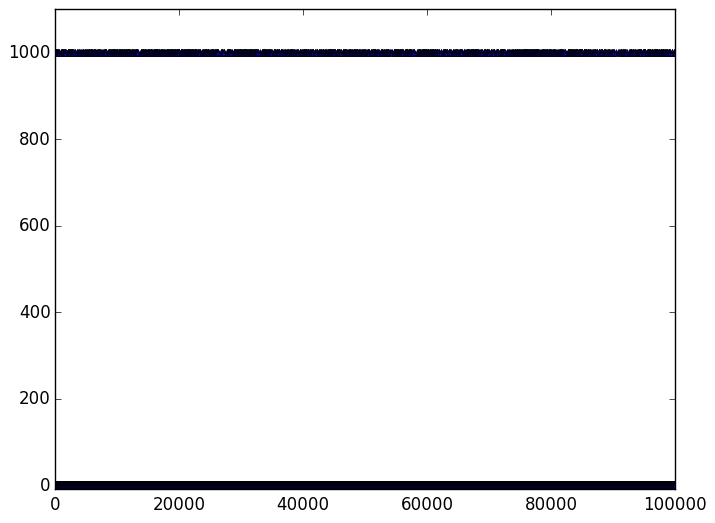

1.5890000000000002

In [35]:
n=100000
r=zeros(n)
z=zeros(n)
for i=1:n
    state=ind2eval(rand(1:stateMap.nSize), stateMap)
    z[i]=zoneDist(state, goal)
    r[i]=Reward(state)
end
plot(r, "b*")
ylim(-10, 1100)
@show minimum(z)
@show maximum(r)
count=0
for i=1:length(r)
    if r[i]>10
        count+=1
    end
end
count/length(r) *100

In [21]:
nSamples = 1000 # number of state samples
w = zeros(BasisSize) #initialize weights
aSize = 243 #number of possible actions
γ = 0.95 # learning rate
uStar = zeros(nSamples) #vector of best value the random state 

#println(size(w))
#println(size(action))

for iters = 1:50
    tic()
    A = zeros(nSamples,BasisSize) #matrix of the basis values for each of the sampled states 
    for i = 1:nSamples
    
        q = zeros(actionMap.nSize) #value of the action at state 
        
        sInd= rand(1:stateMap.nSize) #get random state index
        state = ind2eval(sInd,  stateMap) #evaluate it 
        
        A[i,:] = BasisFun(state, goal)
        for a = 1:actionMap.nSize
            aInd=a #index of action 
            
            #sInd_=detTrans(sInd,aInd, stateMap, actionMap) # get next state
            state_=ind2eval(sInd, stateMap)+ind2eval(aInd, actionMap) #evaluate next state it 
            q[a] += Reward(state, goal) + γ*sum(w.*BasisFun(state_, goal)) #calculate value 
                #println("ok")
        end

        uStar[i] = maximum(q) #get the best one value 
    
    end
    toc()
    wp = (pinv(A)*uStar)
    println(norm(wp - w))
    if norm(wp - w)< 10
        break
    end
    w = wp
end


elapsed time: 39.27708803 seconds
59.8887612920534
elapsed time: 39.322884571 seconds
345.2349216252541
elapsed time: 38.242373156 seconds
3473.139392059395
elapsed time: 38.594062737 seconds
47193.84863856994
elapsed time: 38.122106257 seconds
626781.5153114359
elapsed time: 38.222258912 seconds
8.304572258574349e6
elapsed time: 38.281129086 seconds
1.1052869693403456e8
elapsed time: 39.855334608 seconds
1.4660397068759704e9
elapsed time: 38.760202035 seconds
1.9495569562260727e10
elapsed time: 38.486342921 seconds
2.5836638560580847e11
elapsed time: 38.487822172 seconds
3.431673459824495e12
elapsed time: 38.445173335 seconds
4.554740181261143e13
elapsed time: 38.162556521 seconds
6.069412861632304e14
elapsed time: 38.351812294 seconds
8.014788519727948e15
elapsed time: 38.359203641 seconds
1.0787015072782574e17
elapsed time: 38.23389881 seconds
1.4286926687209492e18
elapsed time: 38.233641782 seconds
1.892483577835824e19
elapsed time: 38.256139784 seconds
2.4976631757978314e20
elapse

In [22]:
w'

1x9 Array{Float64,2}:
 3.85722e55  3.79294e55  3.74282e55  …  3.68847e55  3.69045e55  2.17876e56

In [23]:
tMax=300
state = randEval(stateMap)
traj = zeros(tMax,nSeg)
for i = 1:tMax
    
    traj[i,:]= state 
    
    q = zeros(actionMap.nSize)
    for aInd = 1:actionMap.nSize
        action= ind2eval(aInd, actionMap)
        
        state_=state+action #evaluate possible state
        q[aInd] += Reward(state, goal) + γ*sum(w.*BasisFun(state_, goal)) #calculate value 
    end
    
    aStar=indmax(q)    
    state= state+ind2eval(aStar, actionMap) #update state
end



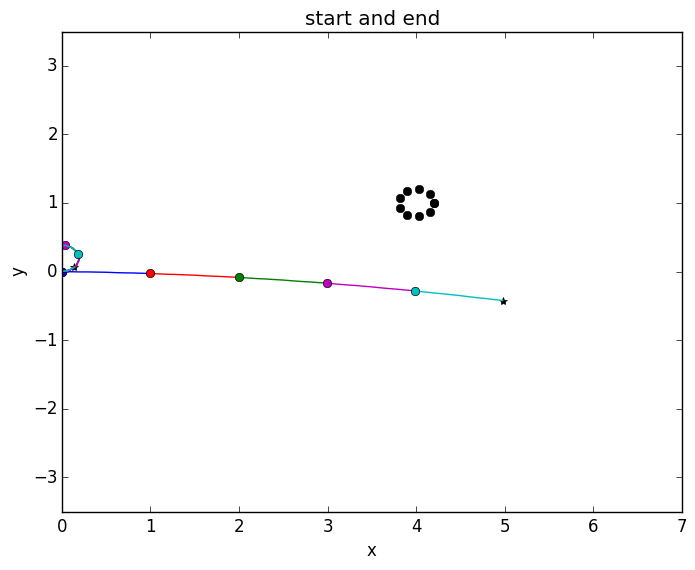

(-3.5,3.5)

In [24]:
(p,e)=ccArm2(traj[1, :])
drawArm(p, e)

(p,e)=ccArm2(traj[end, :])
drawArm(p, e)


drawZone(goal)
title("start and end")
xlabel("x")
ylabel("y")
xlim(-0, 7)
ylim(-3.5, 3.5)

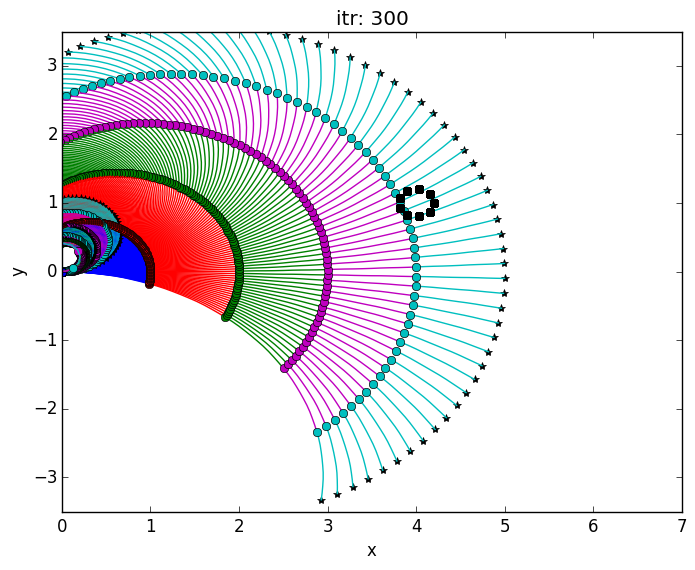

In [20]:
#plot subrut
hold("on")
for i=1:tMax
    (p,e)=ccArm2(traj[i, :])
    drawArm(p, e)
    drawZone(goal)
    title("itr: $(i)")
    xlabel("x")
    ylabel("y")
    xlim(-0, 7)
    ylim(-3.5, 3.5)
end


In [ ]:
state=randEval(stateMap)
@show Reward(randEval(stateMap))
BasisFun(state)

In [ ]:
##james functions


In [12]:
##james's learn 
m = 1000 # number of state samples
w = zeros(BasisSize) #initialize weights
aSize = 243 #number of possible actions
kMax = 1 # number of samples of probabilistic transition - currently 1 because deterministic transition
γ = 0.95 # learning rate
y = zeros(m)
action = [0 0 0 0 0]
#println(size(w))
#println(size(action))

for iters = 1:5

    A = zeros(m,BasisSize)

    for i = 1:m
    
        q = zeros(aSize)
        state = randEval(stateMap)
        A[i,:] = BasisFun(state)

        for j = 1:actionMap.nSize
            action=ind2eval(j, actionMap)
            for k = 1:kMax
                #println(ContReward(state))
                #println(ValApprox(w,ContTrans(state,action)))
                #println(w)
                q[j] += (Reward(state) + γ*sum(w.*BasisFun(ContTrans(state, action))))/kMax
                #println("ok")
            end
        end

        y[i] = maximum(q)
    
    end

    wp = (pinv(A)*y)
    println(norm(wp - w))
    w = wp
end

276.18124171777805
1054.3089036888523
14280.795073484693
191326.08670815034
2.5472737975976337e6


In [ ]:
#james's eval
s = [rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90)]
a = zeros(1,5)
p = zeros(200,2)
for i = 1:200
    
    println(norm(ccQuick(map(deg2rad, s), 1)[end,:] - [4.5 1]))
    p[i,:] = ccQuick(map(deg2rad, s), 1)[end,:]    
    
    q = zeros(aSize)
    for j = 1:243
        action[1],action[2],action[3],action[4],action[5] = ind2sub((3,3,3,3,3),j)
        action -=2
        
        q[j] += (ContReward(s) + γ*ValApprox(w,ContTrans(s,action)))
    end
    
    #println(q)
    
    a[1],a[2],a[3],a[4],a[5] = ind2sub((3,3,3,3,3),findmax(q)[2])
    a-= 2
    #println(a)
    s = ContTrans(s,a)
end

In [ ]:
using PyPlot
plot(p[:,1], p[:,2], "k")